### __About The Data__

The data we'll be using has the following attributes related to heart health:

- age           : The person's age in years
- sex           : The person's sex (1 = male, 0 = female)
- cp            : The chest pain experienced (0 = typical angina, 1 = atypical angina, 2 = non-anginal pain, 3 = asymptomatic)
- trtbps        : The person's resting blood pressure (mm Hg on admission to the hospital)
- chol          : The person's cholesterol measurement in mg/dl
- fbs           : The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
- restecg       : Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
- hr            : The person's maximum heart rate achieved
- exng          : Exercise induced angina (1 = yes; 0 = no)
- oldpeak       : ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot)
- slope         : the slope of the peak exercise ST segment (0 = upsloping, 1 = flat, 2 = downsloping)
- vessels       : The number of major vessels (0 - 4)
- thal          : A blood disorder called thalassemia (0 = normal, 1 = fixed defect, 2 = reversable defect, 3 = unreversable defect)
- heart_disease : Heart disease (0 = no, 1 = yes)


Many of the features come from Electrocardiogram Tests (ECG/EKG), where the electrical rhythms of the heart are measured. Here's an example of an ECG reading:


![ECG Example](ecg.jpg)



### __Problem Statement__

Remember, data science tasks usually involve some sort of stakeholder who wants to learn something from the data, but don't know what to do. That's where you, the data scientist, come in! As part of a consultant group, you are a data scientist who has been contracted by a research team of cardiologists to try and better understand their group of patients. Specifically, they would like for you to:

- Predict whether an incoming patient is likely to have heart disease or not

In this assignment, we will be using K-nearest-neighbors as the classifier



In [1]:
# Data Cleaning and Plotting Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# Data Analysis Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Sets parameters for the entire notebook for Seaborn/Matplotlib plots
rcParams['figure.figsize'] = 10, 7
rcParams.update({'font.size': 12})
sns.set_style('darkgrid')

# Turns off warnings
import warnings
warnings.filterwarnings("ignore")

# If the above codeblock doesn't run, make sure you have each of
# of the packages installed and you are running Python 3.0 or greater

Let's take a look at our data

In [2]:
db = pd.read_csv('data_hw2.csv')
db.head()

,age,sex,cp,bp,chol,fbs,restecg,hr,exng,oldpeak,slope,vessels,thall,heart_disease
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            303 non-null    int64  
 1   sex            303 non-null    int64  
 2   cp             303 non-null    int64  
 3   bp             303 non-null    int64  
 4   chol           303 non-null    int64  
 5   fbs            303 non-null    int64  
 6   restecg        303 non-null    int64  
 7   hr             303 non-null    int64  
 8   exng           303 non-null    int64  
 9   oldpeak        303 non-null    float64
 10  slope          303 non-null    int64  
 11  vessels        303 non-null    int64  
 12  thall          303 non-null    int64  
 13  heart_disease  303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [4]:
db['heart_disease'].sum()

165

### Part 1: Visual Analysis

__Q1:__ How many patients are there?

303

First, we want to get our data ready for analysis.

__Q2:__ The categorical variables in the data set are already encoded, but which features would be considered categorical? (I counted 9, including the dependent variable)

Sex, cp, fbs, restecg, exng, slope, thal, vessels, and heart_disease

__Q3:__ How might categorical variables affect a KNN classifier?

Because the categorical variables are encoded numerically, regardless of if they can be ranked or not, it isn't accurate to plot them like they will be and could result in clusters being closer to one another even if they're distinctly different categorically.

Create the correlation matrix using Pandas, then using Seaborn, plot a heatmap of the correlation matrix that looks similar to the one below.

HINT: Once again, look at [Matplotlib color map options](https://matplotlib.org/stable/tutorials/colors/colormaps.html) to see if you can find a good color scheme for your heatmap to make it more understandable, and play around with different values of the seaborn heatmap function to make it readable. Remember, we want the colors to immediately pop out and tell us what's happening without having to read the numbers. It's much easier to see color differences than read a table of numbers. The job of a data scientist is to make data understandable.

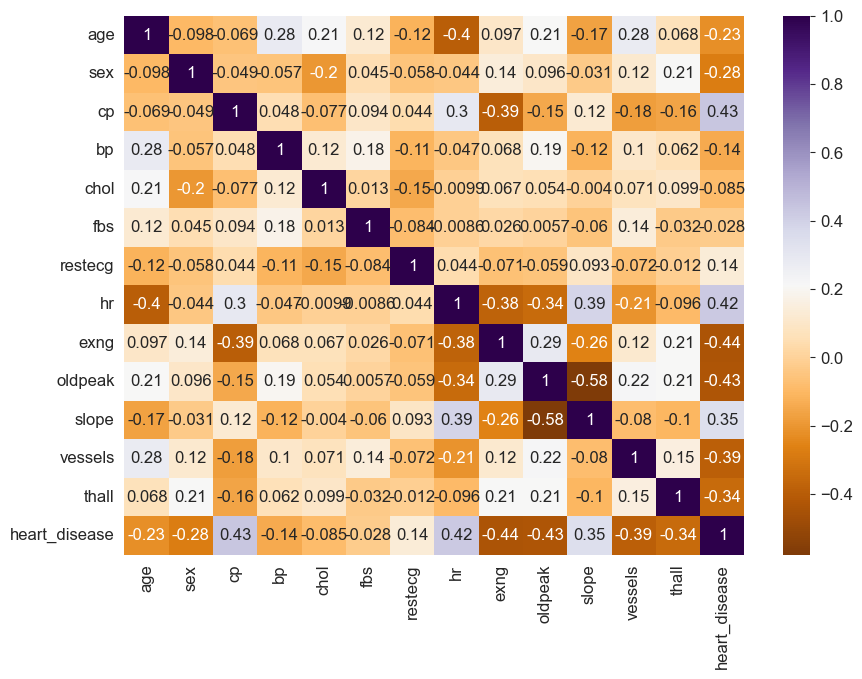

In [5]:
sns.heatmap(db.corr(), cmap = 'PuOr', annot = True)
plt.show()

__Q4:__ What sticks out from the heatmap, and what does it tell us about our data, especially heart disease?

There are several variables that exhibit minor multicollinearity with heart_disease, including chest pain, heart rate, exercised induced agnia. This suggests that exercise that elevates cardiovascular activity can lead to individuals afflicted with heart disease to exhibit symptoms.

Additionally, there is moderate collinearity between slope and oldpeak. Not enough to consider removing either variable from the dataset, but worth bearing in mind when observing the results.

__Q5:__ Do you think this correlation matrix is affected at all by the fact that heart_disease is a categorical variable?

More on [understanding correlation](https://www.mathsisfun.com/data/correlation.html)

I think the correlation between the variables and heart_disease is affected to a certain extent by heart_disease being an encoded categorical variable. Because heart_disease is either 0 or 1 and nothing in between, any slight correlation is made to appear larger because there's no way of expressing it as anything other than a definite yes or no.

We have mostly categorical variables in this data set, and on top of that, we are not medical experts, so the exact definition of some features may not be obvious to us. How can we better understand the data like this?

With something like this, I like using [Seaborn violin plots](https://seaborn.pydata.org/generated/seaborn.violinplot.html), because they are very intuitive.

In my correlation plot, there were 4 variables that had > +/- 0.40 correlation with heart_disease:
- cp
- hr
- exng
- oldpeak

So, let's look at those. Try using a violin plot to create the following images. The features are labeled on the x and y axis. As a tip, make sure the following are included in your function call,

```hue = 'heart_disease'```

```split = True```

Check out the above link to see the documentation for violin plots if you have any questions, or use Google :)

<AxesSubplot:xlabel='cp', ylabel='hr'>

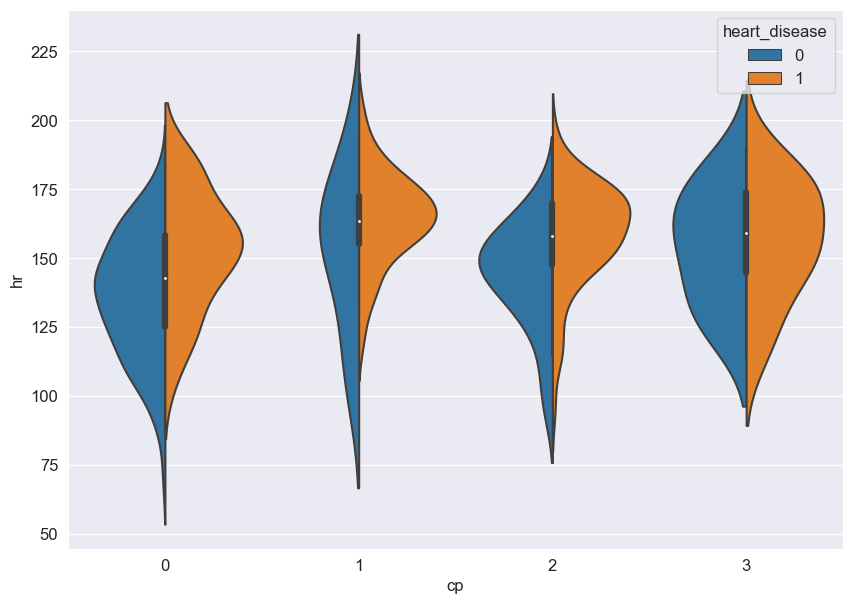

In [6]:
sns.violinplot(x = 'cp', y = 'hr', data = db, hue = 'heart_disease', split = True)

__Q6:__ What can we learn from the above plot about the relations between the 3 features?

A higher heart rate and varying degrees of chest pain do not necessarily imply the presence or lack of heart disease. Additionally, asympototic chest pain has a fairly even split at all points between those that have chest pain and those that don't, which reflects the distribution of the overall data, implying that it does not actually have much impact on the chances of heart disease.

<AxesSubplot:xlabel='exng', ylabel='hr'>

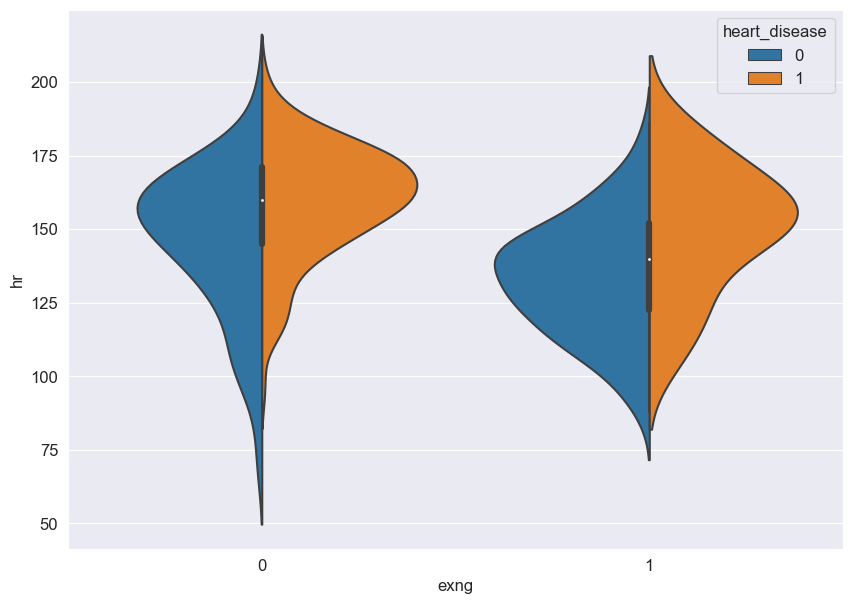

In [7]:
sns.violinplot(x = 'exng', y = 'hr', data = db, hue = 'heart_disease', split = True)

__Q7:__ What can we learn from the above plot about the relations between the 3 features?

Regardless of the presence of an angina, a higher heart rate incures a greater risk of heart disease. However, an angina being present does increase that risk by a small chance for those with a higher heart rate.

<AxesSubplot:xlabel='cp', ylabel='oldpeak'>

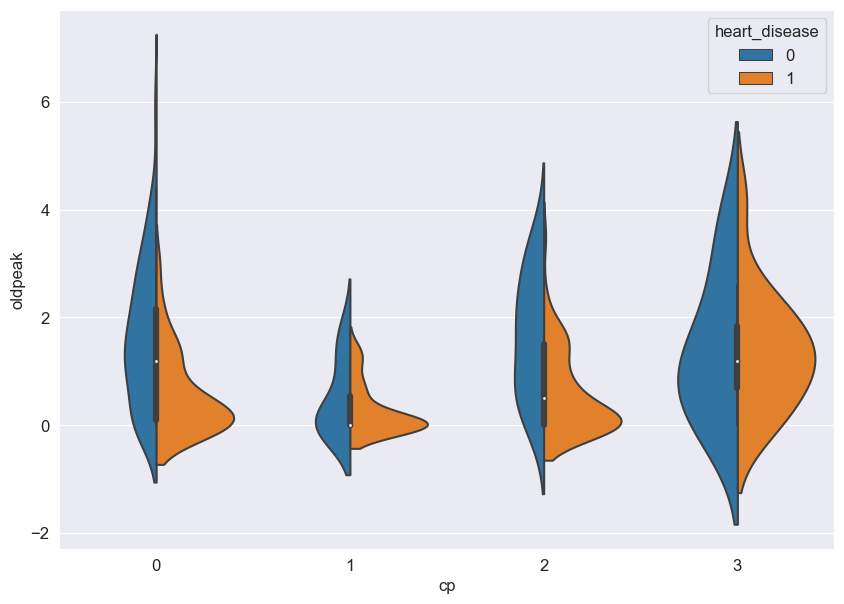

In [8]:
sns.violinplot(x = 'cp', y = 'oldpeak', data = db, hue = 'heart_disease', split = True)

__Q8:__ What can we learn from the above plot about the relations between the 3 features?

A greater old peak implies better health for the arteries and a lower likelihood of blockages. Thus, this explains why across the spectrum, a higher old peak means a lower chance for heart disease and a lack of change implies a greater chance as that means the heart cannot properly pump at the necessary elevated rate for increased activity.

<AxesSubplot:xlabel='exng', ylabel='oldpeak'>

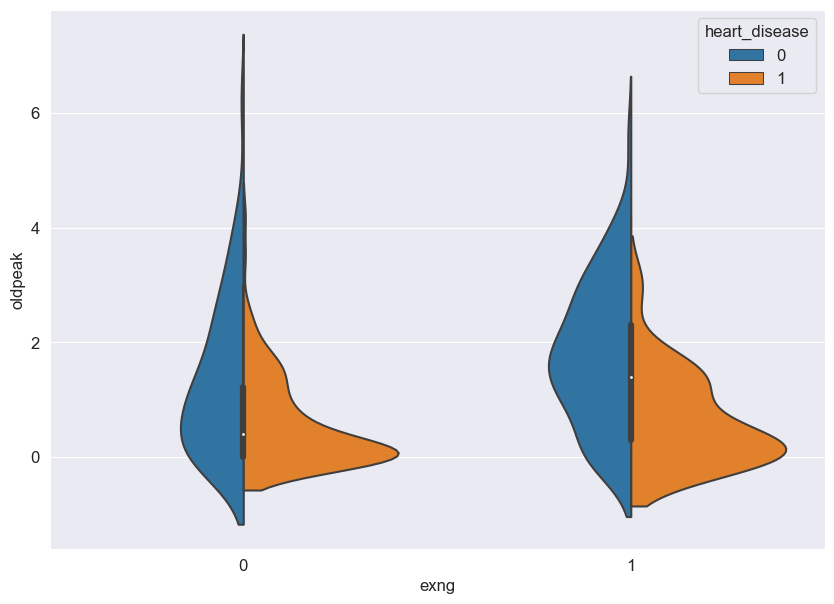

In [9]:
sns.violinplot(x = 'exng', y = 'oldpeak', data = db, hue = 'heart_disease', split = True)

__Q9:__ What can we learn from the above plot about the relations between the 3 features?

As previously observed, a smaller old peak in heart rate induced by exercise implies a great risk of heart disease. However, in addition, the presence of an angina increases this chance further, as seen by the increase in the amount of people with heart disease in the same ranges on both graphs.

As we can see, using violin plots is a unique and cool way to visualize and help us to comprehend how different features are interacting with one another in our data set. There are many other ways to do it, but being able to understand the data set you have is a really important part of any data science project. Visual representations are also super helpful for our brains to help us intuitively understand the data.

### Part 2: KNN Analysis

Since you've had ample experience using Sci-Kit Learn's different functions, you probably recognize by now that almost all of Sci-Kit Learn's classification and regression methods have the same basic structure of 'fit' then 'predict' and maybe some extra functions based on the type of model used (like residuals or coefficients for linear regression). So, for this part, you will be largely on your own, with less detailed instructions. If you have any questions, check out your previous labs, HW1, the lecture notes, or the just google the specific function to see how to use it.

First, let's split and then scale the data. You choose what test_size to use. For the scalar, we know that most of our features do not follow a normal distribution (as most are categorical variables), so we will use the MinMaxScaler(). Create the following:

- train_x    (pandas df)
- test_x     (pandas df)    
- train_y    (array)
- test_y     (array)

In [10]:
scaler = MinMaxScaler()

Xi = db[['age', 'sex', 'cp', 'bp', 'chol', 'fbs', 'restecg', 'hr', 'exng', 'oldpeak', 'slope', 'vessels', 'thall']]
y = db['heart_disease'].copy()
X_scaled = scaler.fit_transform(Xi)
X = pd.DataFrame(data = X_scaled, columns = Xi.columns)

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.3)

X.sample(n = 5)

,age,sex,cp,bp,chol,fbs,restecg,hr,exng,oldpeak,slope,vessels,thall
290,0.666667,1.0,0.000000,0.509434,0.175799,0.0,0.5,0.687023,0.0,0.000000,1.0,0.25,1.000000
183,0.604167,1.0,0.666667,0.169811,0.237443,0.0,0.0,0.717557,0.0,0.403226,0.5,0.25,1.000000
51,0.770833,1.0,0.000000,0.245283,0.401826,0.0,0.0,0.610687,0.0,0.064516,0.5,0.00,0.666667
91,0.583333,1.0,0.000000,0.358491,0.184932,0.0,0.5,0.740458,1.0,0.000000,1.0,0.00,1.000000
223,0.562500,0.0,0.000000,1.000000,0.369863,1.0,0.0,0.473282,1.0,0.645161,0.0,0.50,1.000000


__Q10:__ What test_size did you decide to use?

I used a test size of 0.3

Now, we want to actually run the KNN analysis. Using KNeighborsClassifier and a for loop, run KNN using different values of k, from 2 -> 25. Print them out as they are run.

Make sure to save the accuracies in a list or array, as they will be used later.

In [11]:
test_scores = []
train_scores = []

for i in range(2, 26):
    knn = KNeighborsClassifier(i)
    knn.fit(train_x, train_y)
    train_scores.append(knn.score(train_x, train_y))
    test_scores.append(knn.score(test_x, test_y))
    print("k =", i, '\t Train Accuracy =', train_scores[i - 2], '\t Test Accuracy =', test_scores[i - 2])

k = 2 	 Train Accuracy = 0.8962264150943396 	 Test Accuracy = 0.7032967032967034
k = 3 	 Train Accuracy = 0.9056603773584906 	 Test Accuracy = 0.7692307692307693
k = 4 	 Train Accuracy = 0.8867924528301887 	 Test Accuracy = 0.7582417582417582
k = 5 	 Train Accuracy = 0.8773584905660378 	 Test Accuracy = 0.7912087912087912
k = 6 	 Train Accuracy = 0.8584905660377359 	 Test Accuracy = 0.8131868131868132
k = 7 	 Train Accuracy = 0.8632075471698113 	 Test Accuracy = 0.8241758241758241
k = 8 	 Train Accuracy = 0.839622641509434 	 Test Accuracy = 0.8351648351648352
k = 9 	 Train Accuracy = 0.8490566037735849 	 Test Accuracy = 0.8021978021978022
k = 10 	 Train Accuracy = 0.8443396226415094 	 Test Accuracy = 0.7802197802197802
k = 11 	 Train Accuracy = 0.8301886792452831 	 Test Accuracy = 0.7802197802197802
k = 12 	 Train Accuracy = 0.8301886792452831 	 Test Accuracy = 0.7692307692307693
k = 13 	 Train Accuracy = 0.8207547169811321 	 Test Accuracy = 0.7692307692307693
k = 14 	 Train Accuracy =

Now, do the same thing as above, but try using a different distance function (try 'cosine') as part of the KNearestNeighbors function.

In [12]:
test_scores_cosine = []
train_scores_cosine = []

for i in range(2, 26):
    knn = KNeighborsClassifier(i, metric = 'cosine')
    knn.fit(train_x, train_y)
    train_scores_cosine.append(knn.score(train_x, train_y))
    test_scores_cosine.append(knn.score(test_x, test_y))
    print("k =", i, '\t Train Accuracy =', train_scores_cosine[i - 2], '\t Test Accuracy =', test_scores_cosine[i - 2])

k = 2 	 Train Accuracy = 0.9009433962264151 	 Test Accuracy = 0.7252747252747253
k = 3 	 Train Accuracy = 0.9056603773584906 	 Test Accuracy = 0.7802197802197802
k = 4 	 Train Accuracy = 0.8867924528301887 	 Test Accuracy = 0.7802197802197802
k = 5 	 Train Accuracy = 0.8867924528301887 	 Test Accuracy = 0.8021978021978022
k = 6 	 Train Accuracy = 0.8773584905660378 	 Test Accuracy = 0.8131868131868132
k = 7 	 Train Accuracy = 0.8773584905660378 	 Test Accuracy = 0.8241758241758241
k = 8 	 Train Accuracy = 0.8679245283018868 	 Test Accuracy = 0.8021978021978022
k = 9 	 Train Accuracy = 0.8584905660377359 	 Test Accuracy = 0.8131868131868132
k = 10 	 Train Accuracy = 0.8584905660377359 	 Test Accuracy = 0.7912087912087912
k = 11 	 Train Accuracy = 0.839622641509434 	 Test Accuracy = 0.7802197802197802
k = 12 	 Train Accuracy = 0.8160377358490566 	 Test Accuracy = 0.7912087912087912
k = 13 	 Train Accuracy = 0.8207547169811321 	 Test Accuracy = 0.7692307692307693
k = 14 	 Train Accuracy =

Finally, choose your own distance function from the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.distance_metrics.html#sklearn.metrics.pairwise.distance_metrics). Make sure to save these accuracies as well

In [13]:
test_scores_man = []
train_scores_man = []

for i in range(2, 26):
    knn = KNeighborsClassifier(i, metric = 'manhattan')
    knn.fit(train_x, train_y)
    train_scores_man.append(knn.score(train_x, train_y))
    test_scores_man.append(knn.score(test_x, test_y))
    print("k =", i, '\t Train Accuracy =', train_scores_man[i - 2], '\t Test Accuracy =', test_scores_man[i - 2])

k = 2 	 Train Accuracy = 0.8962264150943396 	 Test Accuracy = 0.7252747252747253
k = 3 	 Train Accuracy = 0.9056603773584906 	 Test Accuracy = 0.7912087912087912
k = 4 	 Train Accuracy = 0.8679245283018868 	 Test Accuracy = 0.8021978021978022
k = 5 	 Train Accuracy = 0.8773584905660378 	 Test Accuracy = 0.7802197802197802
k = 6 	 Train Accuracy = 0.8726415094339622 	 Test Accuracy = 0.7912087912087912
k = 7 	 Train Accuracy = 0.8820754716981132 	 Test Accuracy = 0.7912087912087912
k = 8 	 Train Accuracy = 0.8773584905660378 	 Test Accuracy = 0.8021978021978022
k = 9 	 Train Accuracy = 0.8915094339622641 	 Test Accuracy = 0.8021978021978022
k = 10 	 Train Accuracy = 0.8726415094339622 	 Test Accuracy = 0.7802197802197802
k = 11 	 Train Accuracy = 0.8726415094339622 	 Test Accuracy = 0.7912087912087912
k = 12 	 Train Accuracy = 0.8632075471698113 	 Test Accuracy = 0.7692307692307693
k = 13 	 Train Accuracy = 0.8632075471698113 	 Test Accuracy = 0.7692307692307693
k = 14 	 Train Accuracy 

Now, plot the three different accuracies using SeaBorn lineplots on a single graph/ax. The first line has been added to help you begin. Not all the details have to be shown as the one below, but the graph should still make sense and be readable. You also might use a different distance metric for the 2nd and 3rd models, so it's okay if that's different.

If you want to learn more about how Seaborn/Matplotlib graphs work, check out the documentation.

In [14]:
compress = np.array([test_scores, test_scores_cosine, test_scores_man])
print(compress)
scores = pd.DataFrame({'Euclidean': compress[0, :], 'Cosine': compress[1, :], 'Manhattan': compress[2, :]})
scores.head()

[[0.7032967  0.76923077 0.75824176 0.79120879 0.81318681 0.82417582
  0.83516484 0.8021978  0.78021978 0.78021978 0.76923077 0.76923077
  0.75824176 0.76923077 0.76923077 0.76923077 0.75824176 0.75824176
  0.79120879 0.76923077 0.78021978 0.76923077 0.76923077 0.74725275]
 [0.72527473 0.78021978 0.78021978 0.8021978  0.81318681 0.82417582
  0.8021978  0.81318681 0.79120879 0.78021978 0.79120879 0.76923077
  0.76923077 0.76923077 0.78021978 0.76923077 0.76923077 0.74725275
  0.74725275 0.74725275 0.76923077 0.76923077 0.79120879 0.79120879]
 [0.72527473 0.79120879 0.8021978  0.78021978 0.79120879 0.79120879
  0.8021978  0.8021978  0.78021978 0.79120879 0.76923077 0.76923077
  0.76923077 0.78021978 0.78021978 0.76923077 0.79120879 0.76923077
  0.78021978 0.76923077 0.76923077 0.76923077 0.76923077 0.74725275]]


,Euclidean,Cosine,Manhattan
0,0.703297,0.725275,0.725275
1,0.769231,0.780220,0.791209
2,0.758242,0.780220,0.802198
3,0.791209,0.802198,0.780220
4,0.813187,0.813187,0.791209


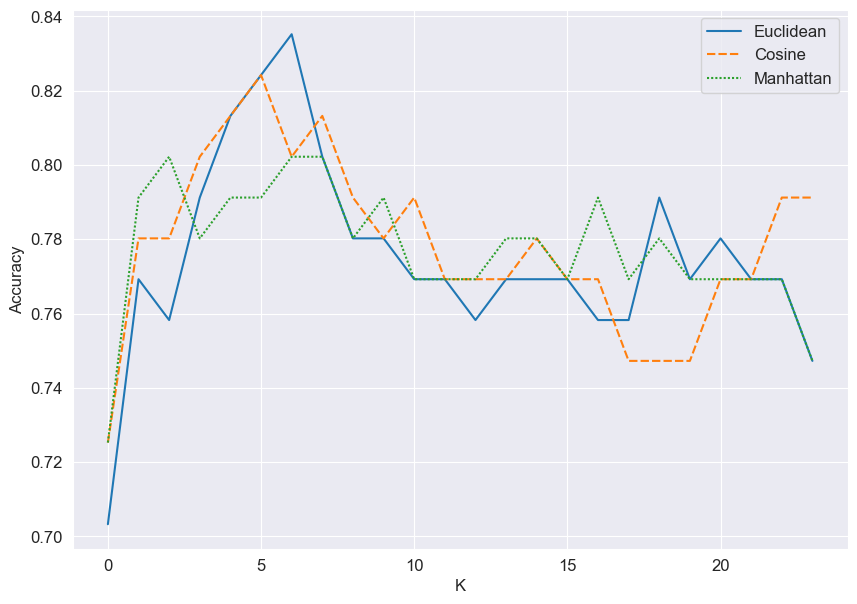

In [15]:
sns.lineplot(data = scores)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

__Q11:__ Which distance function worked best for you? What do you think the benefit of using different distance functions might be? 

On average, it appears Manhattan distance gave me the best results across the values of K. Using various distance functions avoids possible misidentifications based on the method of classification of a certain function. Essentially, it offers various alternatives to find the best possible accuracy for the dataset.

Do any another analysis you see fit or are curious about. Extra work is often rewarded with bonus points!

In [16]:
# A Decision tree and neural network would both work for classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
# Find the best depth
clf_gini = DecisionTreeClassifier(criterion = 'gini', max_depth = 3, random_state = 0)
clf_gini.fit(train_x, train_y)
y_pred_gini = clf_gini.predict(test_x)
print(accuracy_score(test_y, y_pred_gini))
# Check for over fitting
print(clf_gini.score(train_x, train_y))
print(clf_gini.score(test_x, test_y))

0.7582417582417582
0.8820754716981132
0.7582417582417582


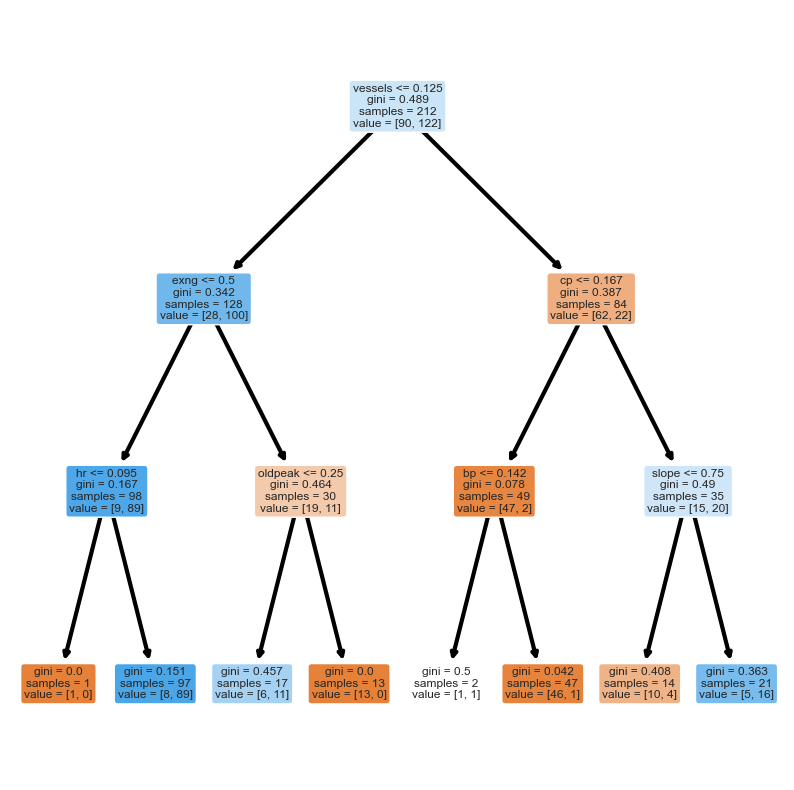

In [18]:
from sklearn import tree
tree.plot_tree(clf_gini)
plt.show()

#fig, ax = plt.subplots(figsize=(10,10))
#out = tree.plot_tree(clf_gini, filled=True, rounded=True, feature_names=['age', 'sex', 'cp', 'bp', 'chol', 'fbs', 'restecg', 'hr', 'exng', 'oldpeak', 'slope', 'vessels', 'thall'])
#for o in out:
#    arrow = o.arrow_patch
#    if arrow is not None:
#        arrow.set_edgecolor('black')
#        arrow.set_linewidth(3)

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

mlp = MLPClassifier(max_iter = 3000, activation = 'logistic', hidden_layer_sizes = (1000, 900))
mlp.fit(train_x, train_y)

predictions = mlp.predict(test_x)

print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, predictions))

[[37 11]
 [ 8 35]]
              precision    recall  f1-score   support

           0       0.82      0.77      0.80        48
           1       0.76      0.81      0.79        43

    accuracy                           0.79        91
   macro avg       0.79      0.79      0.79        91
weighted avg       0.79      0.79      0.79        91



Finally, write your final report about your conclusions. Remember, you should write 1 - 2 paragraphs about what you did, why you did it, and what it means for the stakeholder. I _don't_ just want a summary of the work you did. I know what you did. I want to know what the analysis told you about the data. 

I developed three different predictive models to establish if there was a connection between the given factors and heart disease. Using three different approaches ensured that the established conclusion is more robust to critique given that it helps eliminate potential flaws in any one of the three approaches. That being said, we can conclusively say that the collection of given factors does correlate with heart disease.

Across the board, heart disease exhibits the strongest average absolute correlation among the given variables, such as the presence of an angina or the current blood pressure. This is reflected in all of the models, each exhibiting an accuracy upwards of 73%, meaning a vast majority of the individuals being tested are correctly predicted. This suggests that medical professionals and researchers should focus their efforts on areas such as chest pain, maximum heartrate, and if exercise induces angina in a patient.